In [7]:
from qiskit.qasm import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library.standard_gates import XGate
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_circuit_layout

In [8]:
# Your token can be found here: https://quantum-computing.ibm.com/
API_TOKEN = "?"

In [9]:
# Save account credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
# IBMProvider.save_account(token=API_TOKEN, overwrite=True)

In [10]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
provider = IBMProvider(instance="ibm-q/open/main")

In [11]:
# Use the simulator since is faster
backend = provider.get_backend("ibmq_qasm_simulator")

### A simple experiment where an Rx gate is applied to one qubit get asymmetric results when measuring

In [12]:
# Create a quantum circuit
cr = ClassicalRegister(1, 'c')
qr = QuantumRegister(1, 'a')
qc = QuantumCircuit(qr, cr)

# rotate the one qubit by applying an RX gate corresponding
# to a rotation around X axis with an angle theta 
theta = 2 * pi / 9
qc.rx(theta, 0)
qc.measure(qr, cr)

# Visualize the quantum circuit
qc.draw()

┌──────────┐┌─┐
  a: ┤ Rx(2π/9) ├┤M├
     └──────────┘└╥┘
c: 1/═════════════╩═
                  0

In [7]:
# Transpile circuit and send it to a quantum device or to a simulator
# INSPECT YOUR JOBS HERE: https://quantum-computing.ibm.com/jobs
try:
    transpiled_circuit = transpile(qc, backend=backend, optimization_level=2)
    job = execute(transpiled_circuit, backend, shots=100)
    print(job)
except Exception as ex:
    print(ex.message)

<IBMCircuitJob('cl4aq7iava4gfgvgig7g')>


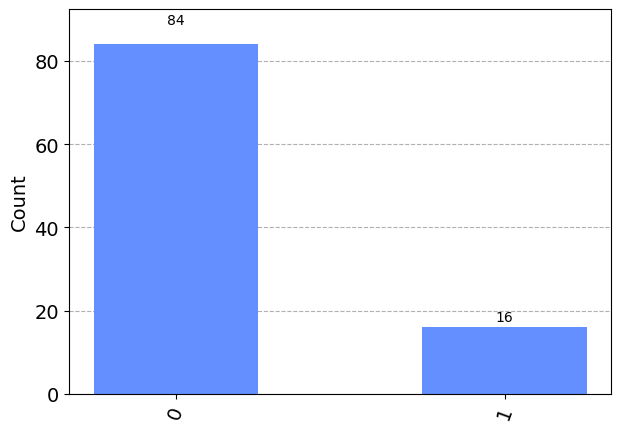

In [8]:
# Get job result
results = job.result()
# Plot job results: these are the result after aplying a quantum gate which rotates one qubit
# with angle theta. Note that the results are not symmetric, 0 state is measured more often than 1
answer = results.get_counts()
plot_histogram(answer)

### Now we are doing the teleportation experiment

In [9]:
# Select quantum device to run on. Select simulator -> True if you want to run on a simulator which is faster
# INSPECT DEVICES YOU HAVE ACCESS TO HERE: https://quantum-computing.ibm.com/services/resources?tab=yours
backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= (len(qc.qubits)) \
    and (x.configuration().simulator == False) and (x.status().operational))
backend = least_busy(backends)
print("Selected the least busy backend: ", backend.name)

Selected the least busy backend:  ibm_nairobi


In [13]:
alice = QuantumRegister(1, 'a')
qubit = QuantumRegister(1, 'q')
bob = QuantumRegister(1, 'b')

classic_alice_register = ClassicalRegister(2, 'alice')
classic_bob_register = ClassicalRegister(1, 'bob')

qc = QuantumCircuit(alice, qubit, bob, classic_alice_register, classic_bob_register)

# Prepare the state of the qubit we will teleport
qc.rx(theta, 1)
qc.barrier()

# Entangle Alice and Bob
qc.h(0)
qc.cx(0, 2)
qc.barrier()

# Entangle Alice and Qubit 
qc.cx(1, 0)
qc.barrier()

# Measure in a basis roated by appplying a hadamard gate
qc.h(1)
qc.measure(1, classic_alice_register[0])
qc.measure(0, classic_alice_register[1])
qc.barrier()

# Finalize teleport procedure using the dynamic circuits capabilities meaning that
# based on measurement results the computation is steered one way or another
with qc.if_test((classic_alice_register[1], 1)):
    qc.x(2)
    
with qc.if_test((classic_alice_register[0], 1)):
    qc.z(2)
qc.barrier()

# Now measure Bob's qubit to verify that the Qubit's state was teleported to Bob
qc.measure(2, classic_bob_register)

# Visualize the quantum circuit
qc.draw()

░ ┌───┐      ░ ┌───┐ ░      ┌─┐    ░             »
      a: ─────────────░─┤ H ├──■───░─┤ X ├─░──────┤M├────░─────────────»
         ┌──────────┐ ░ └───┘  │   ░ └─┬─┘ ░ ┌───┐└╥┘┌─┐ ░             »
      q: ┤ Rx(2π/9) ├─░────────┼───░───■───░─┤ H ├─╫─┤M├─░─────────────»
         └──────────┘ ░      ┌─┴─┐ ░       ░ └───┘ ║ └╥┘ ░ ┌──────────┐»
      b: ─────────────░──────┤ X ├─░───────░───────╫──╫──░─┤0         ├»
                      ░      └───┘ ░       ░       ║  ║  ░ │          │»
alice_0: ══════════════════════════════════════════╬══╩════╡          ╞»
                                                   ║       │          │»
alice_1: ══════════════════════════════════════════╩═══════╡0         ╞»
                                                           └──────────┘»
    bob: ══════════════════════════════════════════════════════════════»
                                                                       »
«                      ░    
«      a: ─────────────░────
«                      ░    
«      q: ─────────────░────
«         ┌──────────┐ ░ ┌─┐
«      b: ┤0         ├─░─┤M├
«         │  If_else │ ░ └╥┘
«alice_0: ╡0         ╞════╬═
«         └──────────┘    ║ 
«alice_1: ════════════════╬═
«                         ║ 
«    bob: ════════════════╩═
«

In [12]:
# Plot qubit coupling map to identify 3 qubits connected
# Here we see that 1 is connected to 2 and is connected to 3
list(backend.coupling_map)

[(0, 1),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 1),
 (3, 1),
 (3, 5),
 (4, 5),
 (5, 3),
 (5, 4),
 (5, 6),
 (6, 5)]

In [13]:
# Transpile the circuit in order to run on a real device
transpiled_circuit = transpile(qc, backend=backend, optimization_level=2, initial_layout=[1,2,3])

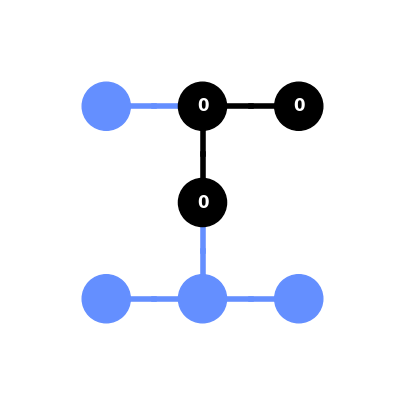

In [14]:
# I want to verify that my qubits that I selected with initial_layout argument are connected
plot_circuit_layout(transpiled_circuit, backend)

In [15]:
# Transpile circuit and send it to a quantum device or to a simulator
# INSPECT YOUR JOBS HERE: https://quantum-computing.ibm.com/jobs
try:
    job = execute(transpiled_circuit, backend, shots=100)
    print(job)
except Exception as ex:
    print(ex.message)

<IBMCircuitJob('cn4atrvrmwhg008k125g')>


In [16]:
# Monitor live the job progress
job_monitor(job, interval=3)

Job Status: job has successfully run


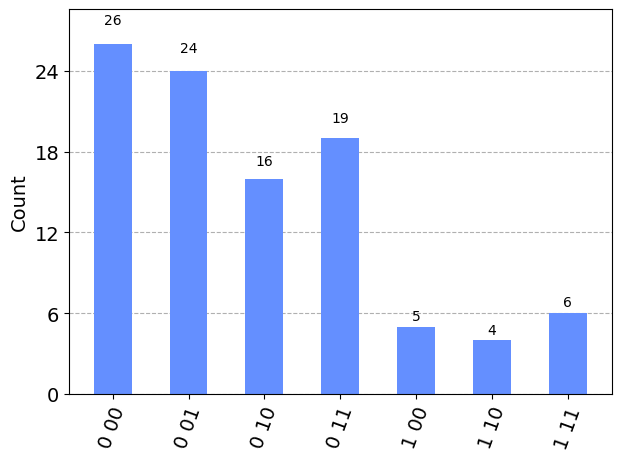

In [17]:
# Get job result
results = job.result()
# Plot job results: these are the result after aplying a quantum gate which rotates one qubit
# with angle theta. Note that the results are not symmetric, 0 state is measured more often than 1
answer = results.get_counts()
plot_histogram(answer)

In [120]:
from qiskit.tools.jupyter import *

%qiskit_version_table